**Author :** Rutendo F. Sigauke


# Summary

- Generate updated normalized counts

- Take the opposite sense strand of gene counts if a bidirectional transcript overlaps a gene. This includes 15kb downstream on PAS and upstream of TSS by 250bp.


# Load libraries

In [1]:
library(data.table) ##fast loading of large tables

# Functions for processing 

## TPM

In [2]:
tpm_calculation <- function(count_g,len_g) {
    
    #' calculate tpms for counts #https://support.bioconductor.org/p/91218/
    #' 
    #' @description This function will calculate tpms for counts table
    #' derived from the same library.  
    #' 
    #' @param count_g data.frame. first counts
    #' 
    #' @param len_g list of integers. Transcript lengths corresponding to count_g
    #' 
    #'
    #' @usage tpm(count_g, len_g)
    #' @return Matix with tpms values for genes as a data.frame
    #' @export

    #get length normalized counts
    g <- count_g/len_g

    #get sum of length normalized counts
    tot_tpms <- colSums(g)

    #calculate the TPMs
    tpm_g <- t(t(g)*1e6/tot_tpms)

    return(tpm_g)   
  
}

## Get strand counts

In [3]:
get_strand_counts <- function(counts, strands, strand_name){
    
    #subset bidirectionals based on the genes' strand
    strands_filts <- subset(strands, gene_strand==strand_name)
    
    #get the counts from the filtered counts
    counts_updated <- counts[counts$bidirs %in% strands_filts$bidirs,]
    return(counts_updated)
}

## Coefficient of variation

In [4]:
cv <- function(x){
    #' calculate coefficient of variation for set of values
    #' 
    #' @description This function will calculate coefficient of variation
    #' 
    #' @param x list of values
    #' 
    #' @usage cv(x)
    #' @return CV value
    #' @export
    
    #sd(x, na.rm=TRUE)/mean(x, na.rm=TRUE)
    sd(x, na.rm=FALSE)/mean(x, na.rm=FALSE)
}

## Summary of transcripts

In [5]:
get_summary_statistics <- function(counts_df, genenames, bidirnames){
    
    #1. transcript lenths
    transcript_lengths <- (counts_df$stop - counts_df$start) +1

    #2. number of columns in the dataframes
    ncolumns <- ncol(counts_df)

    
    ##get summary statistics for bed6+counts data.frame
    #3. transcript coordinated in bed6 format
    df_summary <- counts_df[,1:6]

    #4. get stats like length, st.dev, etc
    df_summary$length <- transcript_lengths
    df_summary$stdev <- apply(counts_df[c(7:ncolumns)], 1, sd)
    df_summary$variance <- apply(counts_df[c(7:ncolumns)], 1, var)
    df_summary$sum <- apply(counts_df[c(7:ncolumns)], 1, sum)
    df_summary$mean <- apply(counts_df[c(7:ncolumns)], 1, mean)
    df_summary$median <- apply(counts_df[c(7:ncolumns)], 1, median)
    df_summary$coefvar <- apply(counts_df[c(7:ncolumns)], 1, cv)
    df_summary$max <- apply(counts_df[c(7:ncolumns)], 1, max)
    df_summary$min <- apply(counts_df[c(7:ncolumns)], 1, min)
    df_summary$num_transcribed <- rowSums(counts_df[c(7:ncolumns)] != 0)
    df_summary$percent_transcribed <- (df_summary$num_transcribed/(ncolumns-6))*100
    df_summary$transcript_type <- ifelse(df_summary$gene_transcript %in% genenames,
                                                 "genes",
                                                 ifelse(df_summary$gene_transcript %in% bidirnames,
                                                        "bidirectional","NA"))
    return(df_summary)
    
}

# Import data

## QC filtered samples

These samples were filtered in the dbNascent paper based on GC content of sample and sample QC.

In [6]:
filtered_samples <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/normalized/human_samples_QC_GC_protocol_filtered.tsv.gz")
nrow(filtered_samples)
head(filtered_samples, 3)

[1] 751

organism,tissue,tissue_description,disease,srp,paper_id,protocol,sample_name,sample_type,cell_type,samp_qc_score,samp_data_score,replicate,control_experimental
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266931,cell line,MV4-11,1,2,1,control
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266932,cell line,MV4-11,2,1,2,control
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266933,cell line,MV4-11,1,2,1,experimental


## Gene counts

- There are `5' Truncated gene annotations` 

In [7]:
counts_genes <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/genes/counts_filt_5ptrunc_gene_stranded_counts.txt',
                                 sep='\t')
dim(counts_genes)
head(counts_genes)

[1] 28889  1651

chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,14361,28620,WASH7P:NR_024540.1,.,-,43,4,45,34,⋯,12,10,38,30,42,62,53,44,49,61
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,34610,35591,FAM138A:NR_026818.1,.,-,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,66168,71585,OR4F5:NM_001005484.2,.,+,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Bidirectional counts

In [8]:
counts_neg_bidirs <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/bidirectionals/counts_bidirectionals_neg.bed',
                                  sep='\t')
counts_neg_bidirs$bidirs <- paste0(counts_neg_bidirs$chrom,':',
                              counts_neg_bidirs$start,'-',
                              counts_neg_bidirs$end)
dim(counts_neg_bidirs)
head(counts_neg_bidirs, 3)

[1] 847521   1651

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3917,4919,chr1:3917-4919,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,5632,6042,chr1:5632-6042,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,6132,6486,chr1:6132-6486,7,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [9]:
counts_pos_bidirs <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/bidirectionals/counts_bidirectionals_pos.bed',
                                  sep='\t')
counts_pos_bidirs$bidirs <- paste0(counts_pos_bidirs$chrom,':',
                              counts_pos_bidirs$start,'-',
                              counts_pos_bidirs$end)
dim(counts_pos_bidirs)
head(counts_pos_bidirs, 3)

[1] 847521   1651

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3917,4919,chr1:3917-4919,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,5632,6042,chr1:5632-6042,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,6132,6486,chr1:6132-6486,7,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [10]:
nsamples <- as.numeric(ncol(counts_pos_bidirs))

counts_bidirs_pos_neg <- cbind(counts_pos_bidirs[,1:6],
                       counts_pos_bidirs[,7:nsamples] + counts_neg_bidirs[,7:nsamples])
dim(counts_bidirs_pos_neg)
head(counts_bidirs_pos_neg, 3)

[1] 847521   1651

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3917,4919,chr1:3917-4919,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,5632,6042,chr1:5632-6042,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,6132,6486,chr1:6132-6486,7,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Bidirectional filters

```sh

module load bedtools/2.28.0

###########################
##0: initialize files    ## 
###########################
wd=/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews
hg38_refseq=/scratch/Shares/dowell/genomes/hg38/ncbi/hg38_refseq_diff53prime_with_putatives.bed  
hg38_bidirs=/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/bidirectionals_dreg_tfit/hg38_tfit_dreg_bidirectionals.bed
genome=/scratch/Shares/dowell/genomes/hg38/ncbi/hg38.chrom.sizes_unsorted
outdir=${wd}/annotations

mkdir -p ${outdir}

########################################################################
#1: get bidirectionals NOT overlapping RefSeq truncated genes         ##
########################################################################

#filter RefSeq annotations so that only the curated gene list is used (NM,NR,NP)
cat ${hg38_refseq} | grep "NM_\|NR_\|NP_" > ${outdir}/hg38_refseq_diff53prime_curated.bed

#add slop 250 bp upstream of TSS (-l 250) and 15kb from PAS (-r 15000)
bedtools slop -i ${hg38_refseq} -g ${genome} -l 250 -r 15000 -s > ${outdir}/hg38_refseq_diff53prime_with_putatives_SLOP.bed

#i: get bidirectional transcripts NOT overlapping RefSeq
#Takes the above steps and puts them together
cat ${hg38_refseq} | grep "NM_\|NR_\|NP_" | bedtools slop -i - -g ${genome} -l 250 -r 15000 -s | bedtools intersect -a ${hg38_bidirs} -b - -wa -v > ${outdir}/hg38_tfit_dreg_bidirectionals_non_genes.bed

#ii: get those that do overlap, along with the gene annotations
#filter RefSeq annotations so that only the curated gene list is used (NM,NR,NP)
#report the number of bases that overlap
cat ${hg38_refseq} | grep "NM_\|NR_\|NP_" | bedtools slop -i - -g ${genome} -l 250 -r 15000 -s | bedtools intersect -a ${hg38_bidirs} -b - -wo > ${outdir}/hg38_tfit_dreg_bidirectionals_in_genes.bed 

########################################################################
#2: get distances between genes and nearest genes. Used for filtering ##
########################################################################
#i: get distances between genes (used to filter those with close genes downstream)                                                                                                                                             
#D - Use negative distances to report upstream features
#a - Report distance with respect to A 
#-k report upto 2 closest
#-S require opposite strandedness
bedtools closest -a ${outdir}/hg38_refseq_diff53prime_curated.bed -b ${outdir}/hg38_refseq_diff53prime_curated.bed -S -D a -k 2 > ${outdir}/hg38_refseq_diff53prime_genes_distances.bed



```

### Bidirectional transcripts NOT overlapping genes

In [11]:
bidir_no_overlaps <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/annotations/hg38_tfit_dreg_bidirectionals_non_genes.bed",
                                   sep="\t")
colnames(bidir_no_overlaps) <- c('chrom','start','end','bidirs',
                             'score','strand')
bidir_no_overlaps$bidirs <- paste0(bidir_no_overlaps$chrom,':',
                              bidir_no_overlaps$start,'-',
                              bidir_no_overlaps$end)

nrow(bidir_no_overlaps)
head(bidir_no_overlaps)

[1] 258345

chrom,start,end,bidirs,score,strand
<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,46585,47033,chr1:46585-47033,3,.
chr1,53210,53580,chr1:53210-53580,1,.
chr1,60170,60510,chr1:60170-60510,1,.
chr1,61756,62124,chr1:61756-62124,1,.
chr1,87654,88246,chr1:87654-88246,4,.
chr1,88908,89232,chr1:88908-89232,7,.


### Bidirectional transcripts DO overlap genes

In [12]:
##load bidirectionals overlapping genes
bidir_overlaps <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/annotations/hg38_tfit_dreg_bidirectionals_in_genes.bed",
                                   sep="\t")
colnames(bidir_overlaps) <- c('chrom','start','end','bidirs',
                             'score','strand', 'gene_chrom',
                             'gene_start','gene_end','gene_id',
                             'gene_score','gene_strand','overlap_len')
bidir_overlaps$bidirs <- paste0(bidir_overlaps$chrom,':',
                              bidir_overlaps$start,'-',
                              bidir_overlaps$end)

##bidirectional regions widths that overlap with genes
bidir_overlaps$bidir_width <- as.numeric(bidir_overlaps$end) - as.numeric(bidir_overlaps$start)
bidir_overlaps$bidir_overlap_perc <- bidir_overlaps$overlap_len/bidir_overlaps$bidir_width

nrow(bidir_overlaps)
head(bidir_overlaps)

[1] 1177667

chrom,start,end,bidirs,score,strand,gene_chrom,gene_start,gene_end,gene_id,gene_score,gene_strand,overlap_len,bidir_width,bidir_overlap_perc
<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
chr1,3917,4919,chr1:3917-4919,14,.,chr1,0,29620,WASH7P:NR_024540.1,.,-,1002,1002,1
chr1,3917,4919,chr1:3917-4919,14,.,chr1,2368,17686,MIR6859-1:NR_106918.1,.,-,1002,1002,1
chr1,5632,6042,chr1:5632-6042,14,.,chr1,0,29620,WASH7P:NR_024540.1,.,-,410,410,1
chr1,5632,6042,chr1:5632-6042,14,.,chr1,2368,17686,MIR6859-1:NR_106918.1,.,-,410,410,1
chr1,6132,6486,chr1:6132-6486,7,.,chr1,0,29620,WASH7P:NR_024540.1,.,-,354,354,1
chr1,6132,6486,chr1:6132-6486,7,.,chr1,2368,17686,MIR6859-1:NR_106918.1,.,-,354,354,1


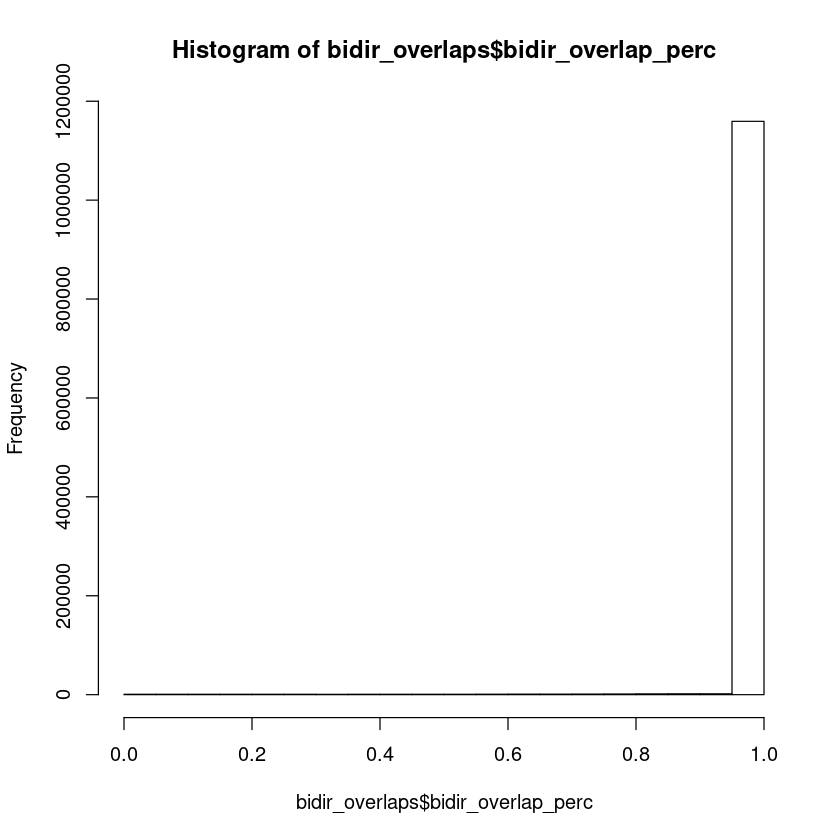

In [13]:
hist(bidir_overlaps$bidir_overlap_perc)

In [14]:
#the number of bidirectional transcripts overlapping genes
print(paste("Number of bidirectionals overlapping genes (250 upstram TSS AND 15kb downstream TES) =", 
            nrow(unique(bidir_overlaps[,c(1,2,3,4)]))))


[1] "Number of bidirectionals overlapping genes (250 upstram TSS AND 15kb downstream TES) = 589176"


In [15]:
##check the total bidirectionals
nrow(bidir_no_overlaps) + nrow(unique(bidir_overlaps[,c(1,2,3,4)]))

[1] 847521

### Gene to gene distances

In [16]:
#load the gene to gene distances
gene_dist <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc_reviews/annotations/hg38_refseq_diff53prime_genes_distances.bed')
nrow(gene_dist)
head(gene_dist)

[1] 95357

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1,14361,29370,WASH7P:NR_024540.1,.,-,0
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,2960
chr1,14361,29370,WASH7P:NR_024540.1,.,-,chr1,11873,14409,DDX11L1:NR_046018.2,.,+,0
chr1,14361,29370,WASH7P:NR_024540.1,.,-,chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,-996
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,chr1,11873,14409,DDX11L1:NR_046018.2,.,+,2960
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,-12930


In [17]:
genes_overlap_opposite_strands_dt <- subset(gene_dist, V13==0)
genes_overlap_opposite_strands <- unique(c(genes_overlap_opposite_strands_dt$V4,
                                                  genes_overlap_opposite_strands_dt$V10))
length(genes_overlap_opposite_strands)
head(genes_overlap_opposite_strands)

[1] 10709

[1] "DDX11L1:NR_046018.2"                 
[2] "WASH7P:NR_024540.1"                  
[3] "LOC107985728:NR_168405.1"            
[4] "SAMD11:NM_001385640.1,NM_001385641.1"
[5] "SAMD11:NM_152486.4"                  
[6] "NOC2L:NM_015658.4"

In [18]:
#remove gene overlapping other opposite strand genes
gene_dist_other_overlaps <- subset(gene_dist, V13!=0)
nrow(gene_dist_other_overlaps)
head(gene_dist_other_overlaps)

[1] 78579

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,2960
chr1,14361,29370,WASH7P:NR_024540.1,.,-,chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,-996
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,chr1,11873,14409,DDX11L1:NR_046018.2,.,+,2960
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,-12930
chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,chr1,14361,29370,WASH7P:NR_024540.1,.,-,-996
chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,chr1,34610,36081,FAM138A:NR_026818.1,.,-,4108


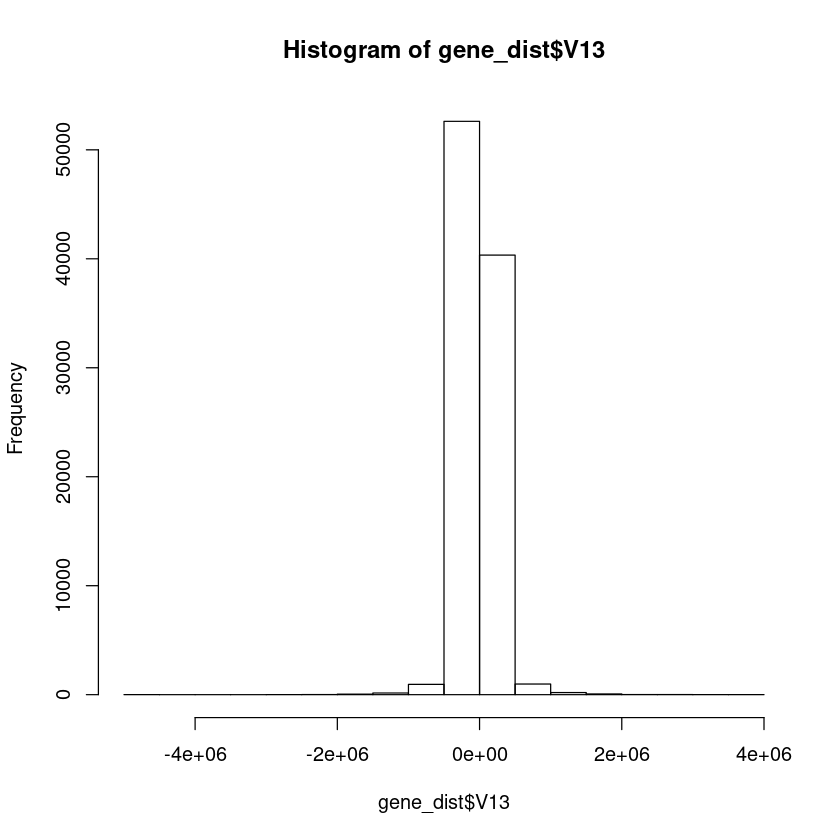

In [19]:
hist(gene_dist$V13)

In [20]:
gene_dist_downstream_15kb_dt <- subset(gene_dist_other_overlaps, V13 >0 & V13 < 7500)
nrow(gene_dist_downstream_15kb_dt)
head(gene_dist_downstream_15kb_dt)
tail(gene_dist_downstream_15kb_dt)

[1] 9177

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,2960
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,chr1,11873,14409,DDX11L1:NR_046018.2,.,+,2960
chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,chr1,34610,36081,FAM138A:NR_026818.1,.,-,4108
chr1,34610,36081,FAM138A:NR_026818.1,.,-,chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,4108
chr1,182387,184878,DDX11L17:NR_148357.1,.,+,chr1,187890,187958,MIR6859-2:NR_107062.1,.,-,3013
chr1,187890,187958,MIR6859-2:NR_107062.1,.,-,chr1,182387,184878,DDX11L17:NR_148357.1,.,+,3013


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
chrY,1386151,1392113,SLC25A6_1:NM_001636.4_1,.,-,chrY,1336784,1382689,"IL3RA_1:NM_002183.4_1,NM_001267713.2_1,XM_005274780.6,XM_005274781.2,XM_017030043.3",.,+,3463
chrY,1397024,1399412,LINC00106_1:NR_130733.1_1,.,+,chrY,1403138,1452909,"ASMTL_1:NM_004192.4_1,NM_001173474.2_1,XM_047442774.1",.,-,3727
chrY,1397024,1399412,LINC00106_1:NR_130733.1_1,.,+,chrY,1403138,1453756,"ASMTL_1:NM_001173473.2_1,XM_005274783.4,XM_047442773.1",.,-,3727
chrY,2609190,2609254,MIR6089_1:NR_106737.1_1,.,+,chrY,2612990,2615347,LINC00102_1:NR_037842.1_1,.,-,3737
chrY,57184215,57197337,"IL9R_1:NM_002186.3_1,NM_176786.2_1",.,+,chrY,57201083,57203350,WASIR1_1:NR_138048.1_1,.,-,3747
chrY,57201083,57203350,WASIR1_1:NR_138048.1_1,.,-,chrY,57184215,57197337,"IL9R_1:NM_002186.3_1,NM_176786.2_1",.,+,3747


In [21]:
gene_dist_downstream_15kb <- unique(c(gene_dist_downstream_15kb_dt$V4, 
                                     gene_dist_downstream_15kb_dt$V10))
length(gene_dist_downstream_15kb)

[1] 7350

In [22]:
overlap_genes <- unique(c(genes_overlap_opposite_strands, 
                         gene_dist_downstream_15kb))
length(overlap_genes)

[1] 16569

# Filter bidirectionals

## Get bidirectionals on opposite strands of overapping genes

In [23]:
head(bidir_overlaps, 3)

chrom,start,end,bidirs,score,strand,gene_chrom,gene_start,gene_end,gene_id,gene_score,gene_strand,overlap_len,bidir_width,bidir_overlap_perc
<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
chr1,3917,4919,chr1:3917-4919,14,.,chr1,0,29620,WASH7P:NR_024540.1,.,-,1002,1002,1
chr1,3917,4919,chr1:3917-4919,14,.,chr1,2368,17686,MIR6859-1:NR_106918.1,.,-,1002,1002,1
chr1,5632,6042,chr1:5632-6042,14,.,chr1,0,29620,WASH7P:NR_024540.1,.,-,410,410,1


In [24]:
#filter regions where bidirectional overlaps genes + 15kb downstream PAS plus 250bp upstream TSS
overlaps_high <- subset(bidir_overlaps, bidir_overlap_perc > 0 ) ##keep this if you want to filter based on %overlap

#get unique bidirectional transcripts by strand
#meaning, if a bidirectional is overlapping more than 50% of two genes + 30kb dPAS
#it is kept for both instances
overlaps_bidirs_unique <- unique(overlaps_high[,c('bidirs','gene_strand')])

#count to get bidirectional transcripts appearing based on strand with table()
#`unique` will return all bidirectionals near same strand transcripts (Freq==1)
#OR bidirectional transcripts near two opposite strand genes (Freq==2)
overlaps_bidirs_counts <- as.data.frame(table(overlaps_bidirs_unique$bidirs))

#get bidirectionals not overlapping two opposite strands
overlaps_bidirs_non_multiple <- subset(overlaps_bidirs_counts, Freq < 2)
nrow(overlaps_bidirs_non_multiple)
head(overlaps_bidirs_non_multiple, 3)

[1] 529446

,Var1,Freq
,<fct>,<int>
1,chr1:1000004-1000574,1
2,chr1:100001920-100002206,1
3,chr1:100002946-100003218,1


In [25]:
#number of transcripts in overlapping genes
overlaps_bidirs_multiple <- subset(overlaps_bidirs_counts, Freq >= 2)
nrow(overlaps_bidirs_multiple)
head(overlaps_bidirs_multiple, 3)
tail(overlaps_bidirs_multiple, 3)

[1] 59730

,Var1,Freq
,<fct>,<int>
53,chr1:100069757-100070077,2
54,chr1:100074130-100074330,2
55,chr1:100074535-100074769,2


,Var1,Freq
,<fct>,<int>
589169,chrY:9494767-9495735,2
589174,chrY:9703970-9704450,2
589175,chrY:9765870-9766390,2


In [26]:
##check the number of overlaps
nrow(overlaps_bidirs_non_multiple) + nrow(overlaps_bidirs_multiple)

[1] 589176

In [27]:
#get bidirectionals not overlapping multiple genes and dPAS
overlaps_non_multiple <- overlaps_high[overlaps_high$bidirs %in% 
                                  as.character(overlaps_bidirs_non_multiple$Var1),]
nrow(overlaps_non_multiple)
head(overlaps_non_multiple, 3)

[1] 979466

chrom,start,end,bidirs,score,strand,gene_chrom,gene_start,gene_end,gene_id,gene_score,gene_strand,overlap_len,bidir_width,bidir_overlap_perc
<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
chr1,3917,4919,chr1:3917-4919,14,.,chr1,0,29620,WASH7P:NR_024540.1,.,-,1002,1002,1
chr1,3917,4919,chr1:3917-4919,14,.,chr1,2368,17686,MIR6859-1:NR_106918.1,.,-,1002,1002,1
chr1,5632,6042,chr1:5632-6042,14,.,chr1,0,29620,WASH7P:NR_024540.1,.,-,410,410,1


In [28]:
length(unique(overlaps_non_multiple$bidirs))

[1] 529446

In [29]:
#get sense counts for bidirectionals overlapping the negative strand
counts_pos_bidirs_overlaps <- get_strand_counts(counts_pos_bidirs,
                                                overlaps_non_multiple,
                                                "-")
nrow(counts_pos_bidirs_overlaps)
head(counts_pos_bidirs_overlaps, 3)

[1] 260012

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,3917,4919,chr1:3917-4919,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,5632,6042,chr1:5632-6042,14,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,6132,6486,chr1:6132-6486,7,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [30]:
#get antisense counts for bidirectionals overlapping the positive strand
counts_neg_bidirs_overlaps <- get_strand_counts(counts_neg_bidirs,
                                                overlaps_non_multiple,
                                                "+")
nrow(counts_neg_bidirs_overlaps)
head(counts_neg_bidirs_overlaps, 3)

[1] 269434

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,36343,36775,chr1:36343-36775,58,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,38375,38929,chr1:38375-38929,58,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,41385,41765,chr1:41385-41765,2,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Get non-gene-overlapping bidirectionals

In [31]:
#######################################################################################################
##remove bidirectional transcripts overlapping genes
##i: overlapping a single gene transcript region : overlaps_non_multiple, and
##ii: overlapping +/- gene transcripts (these are removed) : overlaps_bidirs_multiple
#counts_bidirs_nooverlaps <- counts_bidirs_pos_neg[!counts_bidirs_pos_neg$bidirs
#                                                 %in%
#                                                  unique(c(overlaps_non_multiple$bidirs, 
#                                                    as.character(overlaps_bidirs_multiple$Var1))),]
#nrow(counts_bidirs_nooverlaps)
#head(counts_bidirs_nooverlaps, 3)
#######################################################################################################

##Keep the transcripts overlapping multiple gene and filter after based on whether the upstream transcripts are 
##transcribed
counts_bidirs_nooverlaps <- counts_bidirs_pos_neg[!counts_bidirs_pos_neg$bidirs
                                                 %in%
                                                  unique(overlaps_non_multiple$bidirs),]
nrow(counts_bidirs_nooverlaps)
head(counts_bidirs_nooverlaps, 3)

[1] 318075

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,12182,12456,chr1:12182-12456,1,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,13264,13506,chr1:13264-13506,14,.,4,3,8,6,⋯,11,9,5,4,2,2,4,2,0,6
chr1,14655,14811,chr1:14655-14811,14,.,1,0,0,1,⋯,1,0,0,0,0,0,0,0,0,0


In [32]:
length(unique(c(overlaps_non_multiple$bidirs, as.character(overlaps_bidirs_multiple$Var1))))

[1] 589176

In [33]:
length(unique(overlaps_non_multiple$bidirs))

[1] 529446

## Combine bidirection pos, neg and both strand counts

In [34]:
counts_bidirs <- rbind(counts_bidirs_nooverlaps,
                       counts_pos_bidirs_overlaps, 
                       counts_neg_bidirs_overlaps)
nrow(counts_bidirs)
head(counts_bidirs, 3)

[1] 847521

chrom,start,end,bidirs,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,12182,12456,chr1:12182-12456,1,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,13264,13506,chr1:13264-13506,14,.,4,3,8,6,⋯,11,9,5,4,2,2,4,2,0,6
chr1,14655,14811,chr1:14655-14811,14,.,1,0,0,1,⋯,1,0,0,0,0,0,0,0,0,0


# Combine all counts

In [35]:
counts_bidir_genes_trunc <- as.data.frame(rbind(counts_genes, 
                                          counts_bidirs,
                                        use.names=FALSE))

dim(counts_bidir_genes_trunc)
head(counts_bidir_genes_trunc, 3)
tail(counts_bidir_genes_trunc, 3)

[1] 876410   1651

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,43,4,45,34,⋯,12,10,38,30,42,62,53,44,49,61
3,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
876408,chrY,25633930,25634690,chrY:25633930-25634690,1,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
876409,chrY,25639750,25640170,chrY:25639750-25640170,1,.,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
876410,chrY,25738260,25738790,chrY:25738260-25738790,1,.,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# Normalize counts

In [36]:
##get variables for the TPM calculation function
##and calculate normalized counts

#1. transcript lenths
transcript_lengths <- (counts_bidir_genes_trunc$stop - counts_bidir_genes_trunc$start) +1

#2. number of columns in the dataframes
ncolumns <- ncol(counts_bidir_genes_trunc)

#3. get normalized counts by sample
gene_bidir_tpms <- tpm_calculation(counts_bidir_genes_trunc[,7:ncolumns], 
                        transcript_lengths)

#4. merge the transcript annotations with normalized counts data.frame
gene_bidir_tpm_df <- cbind(counts_bidir_genes_trunc[,1:6],
                           as.data.frame(gene_bidir_tpms))

#summary of data.frame
dim(gene_bidir_tpm_df)
head(gene_bidir_tpm_df)

[1] 876410   1651

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713716,SRR3713717,SRR3713718,SRR3713719,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,0.2372728,0.04812349,0.247163,0.180835,⋯,0.05880973,0.06709094,0.2776161,0.1448111,0.3800877,0.4256579,0.3585765,0.3028641,0.3857214,0.4399284
3,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
4,chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
5,chr1,34610,35591,FAM138A:NR_026818.1,.,-,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
6,chr1,66168,71585,OR4F5:NM_001005484.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


## Save normalized counts

In [37]:
data.table::fwrite(gene_bidir_tpm_df,
                   "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/gene_bidir_tpm.tsv.gz",
                  sep='\t')

In [ ]:
gene_bidir_tpm_qc <- gene_bidir_tpm_df[,colnames(gene_bidir_tpm_df) %in%
                                         c('chrom','start','stop',
                                            'gene_transcript','score',
                                            'strand',metadata_celltype$sample_name),
                                           with=FALSE]
dim(gene_bidir_tpm_qc)
head(gene_bidir_tpm_qc)

In [ ]:
#binary for trancribed or not
tpm_matrix_binary <- ifelse(gene_bidir_tpm_qc[,c(7:757)] != 0, 1, 0)
head(tpm_matrix_binary)

In [ ]:
gene_bidir_tpm_keep2 <- gene_bidir_tpm_qc[rowSums(tpm_matrix_binary)>2,]
dim(gene_bidir_tpm_keep2)

In [ ]:
data.table::fwrite(gene_bidir_tpm_keep2,
                   "/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/counts/normalized_counts/gene_bidir_tpm_qc.tsv.gz",
                  sep='\t')

# Filter samples

In [39]:
##filter all bidirectional and gene transcripts
gene_bidir_tpm_samples_filtered <- cbind(gene_bidir_tpm_df[,1:6], 
                                         gene_bidir_tpm_df[,
                                                           colnames(gene_bidir_tpm_df)
                                                           %in% filtered_samples$sample_name])
                                                           #with=FALSE])
dim(gene_bidir_tpm_samples_filtered)
head(gene_bidir_tpm_samples_filtered, 3)

[1] 876410    757

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713715,SRR3713716,SRR3713717,SRR3713718,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,0.2372728,0.04812349,0.247163,0.180835,⋯,0.09228832,0.05880973,0.06709094,0.2776161,0.3800877,0.4256579,0.3585765,0.3028641,0.3857214,0.4399284
3,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


# Get summary statistics for counts

In [40]:
#convert dt to df
gene_bidir_tpm_samples_filtered_df <- as.data.frame(gene_bidir_tpm_samples_filtered) ##gene_bidir_tpm_df

genes <- gene_bidir_tpm_df[!gene_bidir_tpm_df$gene_transcript 
                                         %in%
                                         counts_bidirs$bidirs,]
                                         
##get summary statistics based on the filtered samples
gene_bidir_tpm_filtered_summary <- get_summary_statistics(gene_bidir_tpm_samples_filtered_df,
                                                genes$gene_transcript,
                                                counts_bidirs$bidirs)
dim(gene_bidir_tpm_filtered_summary)
head(gene_bidir_tpm_filtered_summary, 3)

[1] 876410     18

,chrom,start,stop,gene_transcript,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,1787,0.07496376,0.005619565,7.345779,0.00978133,0.0000000,7.6639642,1.256177,0,29,3.861518,genes
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,14260,0.20321583,0.041296674,186.403807,0.24820747,0.1942185,0.8187338,1.417130,0,749,99.733688,genes
3,chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,69,0.00000000,0.000000000,0.000000,0.00000000,0.0000000,NaN,0.000000,0,0,0.000000,genes


In [41]:
##add a column with bidirectional types (intergenic, intragenic, intragenic and overlapping pos+neg genes)
gene_bidir_tpm_filtered_summary$bidirectional_type <- ifelse(gene_bidir_tpm_filtered_summary$gene_transcript %in% counts_genes$gene_transcript,
                                                 "genes",
                                                 ifelse(gene_bidir_tpm_filtered_summary$gene_transcript %in% bidir_no_overlaps$bidirs,
                                                        "intergenic_bidirectional",
                                                       ifelse(gene_bidir_tpm_filtered_summary$gene_transcript %in% as.character(overlaps_bidirs_non_multiple$Var1),
                                                             "intragenic_bidirectional",
                                                             ifelse(gene_bidir_tpm_filtered_summary$gene_transcript %in% as.character(overlaps_bidirs_multiple$Var1),
                                                                   "intragenic_bidirectional_pos_neg","NA"))))

In [42]:
table(gene_bidir_tpm_filtered_summary$bidirectional_type)


                           genes         intergenic_bidirectional 
                           28889                           258345 
        intragenic_bidirectional intragenic_bidirectional_pos_neg 
                          529446                            59730 

In [43]:
data.table::fwrite(gene_bidir_tpm_filtered_summary,
                   "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/summary_gene_bidir_tpm_filtered.tsv.gz",
                  sep='\t')

# Filter transcripts

## Remove transcripts with 0 total counts

In [44]:
gene_bidir_tpm_filtered_summary_txped <- subset(gene_bidir_tpm_filtered_summary, 
                                                num_transcribed >=10)
nrow(gene_bidir_tpm_filtered_summary_txped)

[1] 837180

In [45]:
##get transcripts with counts in 10 or more samples
gene_bidir_tpm_samples_filtered_txped <- gene_bidir_tpm_samples_filtered[gene_bidir_tpm_samples_filtered$gene_transcript 
                                                                        %in%
                                                                        gene_bidir_tpm_filtered_summary_txped$gene_transcript,]
nrow(gene_bidir_tpm_samples_filtered_txped)
head(gene_bidir_tpm_samples_filtered_txped, 3)

[1] 837180

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713715,SRR3713716,SRR3713717,SRR3713718,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,0.2372728,0.04812349,0.247163,0.180835,⋯,0.09228832,0.05880973,0.06709094,0.2776161,0.3800877,0.4256579,0.3585765,0.3028641,0.3857214,0.4399284
6,chr1,66168,71585,OR4F5:NM_001005484.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


## Split bidirectionals for easy processing

### Intergenic bidirectionals

In [46]:
intergenic_bidirs_genes <- c(genes$gene_transcript,
                             bidir_no_overlaps$bidirs)
length(intergenic_bidirs_genes)

[1] 287234

In [47]:
gene_bidir_tpm_intergenic <- gene_bidir_tpm_samples_filtered_txped[gene_bidir_tpm_samples_filtered_txped$gene_transcript 
                                                                          %in%
                                                                   intergenic_bidirs_genes,]
dim(gene_bidir_tpm_intergenic)
head(gene_bidir_tpm_intergenic, 3)

[1] 280180    757

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713715,SRR3713716,SRR3713717,SRR3713718,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,0.2372728,0.04812349,0.247163,0.180835,⋯,0.09228832,0.05880973,0.06709094,0.2776161,0.3800877,0.4256579,0.3585765,0.3028641,0.3857214,0.4399284
6,chr1,66168,71585,OR4F5:NM_001005484.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [48]:
#how many bidirectionals and genes are in the set
check_intergenic <- gene_bidir_tpm_filtered_summary[gene_bidir_tpm_filtered_summary$gene_transcript 
                                 %in% 
                                 gene_bidir_tpm_intergenic$gene_transcript,]

table(check_intergenic$transcript_type)


bidirectional         genes 
       252181         27999 

In [49]:
data.table::fwrite(gene_bidir_tpm_intergenic,
                   "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/gene_bidir_tpm_intergenic.tsv.gz",
                  sep='\t')

### Intragenic bidirectionals

In [50]:
##list of all intergenic bidirectionals
set.seed(42)

#shuffle the list of bidirectionals so that when they are split into chunks,
#there is roughly an even split of chromosomes
bidir_overlaps_list <- sample(unique(bidir_overlaps$bidirs))
length(bidir_overlaps_list)

[1] 589176

In [51]:
#divide these transcripts into two sets
length(bidir_overlaps_list)/3

[1] 196392

In [52]:
intragenic_bidirs_genes_A <- c(genes$gene_transcript,
                             head(bidir_overlaps_list, 196392))
length(intragenic_bidirs_genes_A)

[1] 225281

In [53]:
intragenic_bidirs_genes_B <- c(genes$gene_transcript,
                             tail(bidir_overlaps_list, 196392))
length(intragenic_bidirs_genes_B)

[1] 225281

In [54]:
intragenic_bidirs_genes_C <- c(genes$gene_transcript, 
                               setdiff(bidir_overlaps_list,
                                         c(intragenic_bidirs_genes_A,intragenic_bidirs_genes_B)))
length(intragenic_bidirs_genes_C)

[1] 225281

In [55]:
##Check that the bidirectional transcripts do not overlap
intersect(tail(bidir_overlaps_list, 294588),
         head(bidir_overlaps_list, 294589))

[1] "chr10:67151630-67151942"

In [56]:
gene_bidir_tpm_intragenic_A <- gene_bidir_tpm_samples_filtered_txped[gene_bidir_tpm_samples_filtered_txped$gene_transcript 
                                                                          %in%
                                                                   intragenic_bidirs_genes_A,]
dim(gene_bidir_tpm_intragenic_A)
head(gene_bidir_tpm_intragenic_A, 3)

[1] 213784    757

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713715,SRR3713716,SRR3713717,SRR3713718,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,0.2372728,0.04812349,0.247163,0.180835,⋯,0.09228832,0.05880973,0.06709094,0.2776161,0.3800877,0.4256579,0.3585765,0.3028641,0.3857214,0.4399284
6,chr1,66168,71585,OR4F5:NM_001005484.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [57]:
gene_bidir_tpm_intragenic_B <- gene_bidir_tpm_samples_filtered_txped[gene_bidir_tpm_samples_filtered_txped$gene_transcript 
                                                                          %in%
                                                                   intragenic_bidirs_genes_B,]
dim(gene_bidir_tpm_intragenic_B)
head(gene_bidir_tpm_intragenic_B, 3)

[1] 213646    757

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713715,SRR3713716,SRR3713717,SRR3713718,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,0.2372728,0.04812349,0.247163,0.180835,⋯,0.09228832,0.05880973,0.06709094,0.2776161,0.3800877,0.4256579,0.3585765,0.3028641,0.3857214,0.4399284
6,chr1,66168,71585,OR4F5:NM_001005484.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [58]:
gene_bidir_tpm_intragenic_C <- gene_bidir_tpm_samples_filtered_txped[gene_bidir_tpm_samples_filtered_txped$gene_transcript 
                                                                          %in%
                                                                   intragenic_bidirs_genes_C,]
dim(gene_bidir_tpm_intragenic_C)
head(gene_bidir_tpm_intragenic_C, 3)

[1] 213567    757

,chrom,start,stop,gene_transcript,score,strand,SRR7266931,SRR7266932,SRR7266933,SRR7266934,⋯,SRR3713715,SRR3713716,SRR3713717,SRR3713718,SRR8483105,SRR8483106,SRR8483107,SRR8483108,SRR8483109,SRR8483110
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,12623,14409,DDX11L1:NR_046018.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,chr1,14361,28620,WASH7P:NR_024540.1,.,-,0.2372728,0.04812349,0.247163,0.180835,⋯,0.09228832,0.05880973,0.06709094,0.2776161,0.3800877,0.4256579,0.3585765,0.3028641,0.3857214,0.4399284
6,chr1,66168,71585,OR4F5:NM_001005484.2,.,+,0.0000000,0.00000000,0.000000,0.000000,⋯,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [59]:
data.table::fwrite(gene_bidir_tpm_intragenic_A,
                   "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/gene_bidir_tpm_intragenic_A.tsv.gz",
                  sep='\t')

In [60]:
data.table::fwrite(gene_bidir_tpm_intragenic_B,
                   "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/gene_bidir_tpm_intragenic_B.tsv.gz",
                  sep='\t')

In [61]:
data.table::fwrite(gene_bidir_tpm_intragenic_C,
                   "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/gene_bidir_tpm_intragenic_C.tsv.gz",
                  sep='\t')

## Check per-chromosome number of transcripts

In [62]:
as.data.frame(table(gene_bidir_tpm_intergenic$chrom))

Var1,Freq
<fct>,<int>
chr1,23247
chr10,12333
chr11,11868
chr12,13062
chr13,9058
chr14,8964
chr15,8094
chr16,7696
chr17,7634


In [63]:
as.data.frame(table(gene_bidir_tpm_intragenic_A$chrom))

Var1,Freq
<fct>,<int>
chr1,20462
chr10,10011
chr11,10635
chr12,10961
chr13,5071
chr14,6800
chr15,7458
chr16,7505
chr17,10301


In [64]:
as.data.frame(table(gene_bidir_tpm_intragenic_B$chrom))

Var1,Freq
<fct>,<int>
chr1,20635
chr10,9951
chr11,10892
chr12,10824
chr13,5165
chr14,6768
chr15,7403
chr16,7514
chr17,10333


In [65]:
as.data.frame(table(gene_bidir_tpm_intragenic_C$chrom))

Var1,Freq
<fct>,<int>
chr1,20521
chr10,10290
chr11,10703
chr12,10775
chr13,5137
chr14,6729
chr15,7535
chr16,7385
chr17,10243


# Session information

In [66]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] data.table_1.14.2

loaded via a namespace (and not attached):
 [1] fansi_1.0.3       crayon_1.5.1      digest_0.6.29     utf8_1.2.2       
 [5] R.methodsS3_1.8.2 IRdisplay_1.1     repr_1.1.4        lifecycle_1.0.3  
 [9] jsonlite_1.8.0    evaluate_0.16     pillar_1.8.1      rlang_1.0.6      
[13] cli_3.4.1         uuid_1.1-0     